In [3]:
!pip install keras --user

  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl


In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torchxrayvision as xrv

In [2]:
def load_train_data():
    train_data = xrv.datasets.COVID19_Dataset(imgpath="/covid_data")
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = bs, num_workers = 0, shuffle=True)
    return train_loader

def load_test_data():
    data = XRayDataset(test_path)
    test_loader = torch.utils.data.DataLoader(data, batch_size = bs, num_workers = 0, shuffle=True)
    return test_loader

In [46]:
data = xrv.datasets.COVID19_Dataset(imgpath="/covid_data")
print(data)

{'ARDS': {0.0: 75, 1.0: 4},
 'Bacterial Pneumonia': {0.0: 73, 1.0: 6},
 'COVID-19': {0.0: 23, 1.0: 56},
 'MERS': {0.0: 79},
 'No Finding': {0.0: 78, 1.0: 1},
 'Pneumonia': {0.0: 2, 1.0: 77},
 'SARS': {0.0: 68, 1.0: 11},
 'Streptococcus': {0.0: 73, 1.0: 6},
 'Viral Pneumonia': {0.0: 12, 1.0: 67}}
COVID19_Dataset num_samples=79


In [41]:
data_loader = DataLoader(data, batch_size=100,shuffle=True)
print(data_loader)

In [43]:
data_loader('COVID-19')

TypeError: 'DataLoader' object is not callable

In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
train_data_path = 'train'
test_data_path = 'test'
# val_data_path = 'covid'

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

W0317 00:46:23.791200 139634463156032 deprecation_wrapper.py:119] From /home/x5he/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [6]:
for layer in vgg.layers:
    layer.trainable = False

In [7]:
folders = glob('train/*')
folders

['train/noncovid', 'train/covid']

In [8]:
x = Flatten()(vgg.output)
print(x)

Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)


In [9]:
prediction = Dense(len(folders)+1, activation='softmax')(x)
print(prediction)

Tensor("dense_1/Softmax:0", shape=(?, 3), dtype=float32)


In [10]:
model = Model(inputs=vgg.input, outputs=prediction)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=IMAGE_SIZE + [3]))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())

W0317 00:06:35.747097 140003753445184 deprecation_wrapper.py:119] From /home/x5he/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 99,143,107
Trainable params: 99,143,107
Non-trainable params: 0
__________________________________________

In [52]:
from keras import backend as K
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return y_pred
    
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return y_true
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
#     metrics=['accuracy',f1, precision, recall]
    metrics=['accuracy']
)

In [12]:
train_dataGen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_dataGen = ImageDataGenerator(rescale=1./255)

training_set = train_dataGen.flow_from_directory('train',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')
test_set = test_dataGen.flow_from_directory('test',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 87 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [15]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2)

# training_set = train_datagen.flow_from_directory(
#     'covid',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     subset='training')

# test_set = train_datagen.flow_from_directory(
#     'covid',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     subset='validation')

In [13]:
# Fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1000,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

W0317 00:47:11.953080 139634463156032 deprecation_wrapper.py:119] From /home/x5he/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/1000
3/3 [==============================] - 5s 2s/step - loss: 0.8402 - accuracy: 0.8391 - val_loss: 1.2229 - val_accuracy: 0.4167
Epoch 2/1000
3/3 [==============================] - 3s 900ms/step - loss: 0.6261 - accuracy: 0.6552 - val_loss: 1.1720 - val_accuracy: 0.6944
Epoch 3/1000
3/3 [==============================] - 4s 1s/step - loss: 0.4910 - accuracy: 0.8391 - val_loss: 1.3104 - val_accuracy: 0.6944
Epoch 4/1000
3/3 [==============================] - 4s 1s/step - loss: 0.3982 - accuracy: 0.8046 - val_loss: 0.9709 - val_accuracy: 0.7500
Epoch 5/1000
3/3 [==============================] - 4s 1s/step - loss: 0.3358 - accuracy: 0.8046 - val_loss: 1.3136 - val_accuracy: 0.6944
Epoch 6/1000
3/3 [==============================] - 4s 1s/step - loss: 0.2970 - accuracy: 0.8391 - val_loss: 0.2222 - val_accuracy: 0.6944
Epoch 7/1000
3/3 [==============================] - 4s 1s/step - loss: 0.2453 - accuracy: 0.9080 - val_loss: 0.1035 - val_accuracy: 0.8333
Epoch 8/1000
3/3 [======

3/3 [==============================] - 4s 1s/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 1.2047 - val_accuracy: 0.8056
Epoch 60/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 2.5943 - val_accuracy: 0.8056
Epoch 61/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.8056
Epoch 62/1000
3/3 [==============================] - 3s 1s/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.2107 - val_accuracy: 0.8056
Epoch 63/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.8056
Epoch 64/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 1.2307 - val_accuracy: 0.7778
Epoch 65/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.9580 - val_accuracy: 0.8056
Epoch 66/1000
3/3 [===============

3/3 [==============================] - 4s 1s/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 1.3827 - val_accuracy: 0.7778
Epoch 118/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 1.8808 - val_accuracy: 0.7778
Epoch 119/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.8056
Epoch 120/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.8611
Epoch 121/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.8611
Epoch 122/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 4.1789 - val_accuracy: 0.8333
Epoch 123/1000
3/3 [==============================] - 10s 3s/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 2.4367e-04 - val_accuracy: 0.7778
Epoch 124/1000
3/3 [===

3/3 [==============================] - 3s 1s/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.1145 - val_accuracy: 0.8333
Epoch 176/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 5.2664 - val_accuracy: 0.8056
Epoch 177/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.8056
Epoch 178/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0552 - val_accuracy: 0.8611
Epoch 179/1000
3/3 [==============================] - 10s 3s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.9846 - val_accuracy: 0.8611
Epoch 180/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 2.0822 - val_accuracy: 0.8611
Epoch 181/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.8056
Epoch 182/1000
3/3 [=======

3/3 [==============================] - 4s 1s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.5000 - val_accuracy: 0.8611
Epoch 234/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.9728 - val_accuracy: 0.8611
Epoch 235/1000
3/3 [==============================] - 11s 4s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.8333
Epoch 236/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.8056
Epoch 237/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.3717 - val_accuracy: 0.8056
Epoch 238/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1835 - val_accuracy: 0.8056
Epoch 239/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.8333
Epoch 240/1000
3/3 [=======

3/3 [==============================] - 4s 1s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.8056
Epoch 292/1000
3/3 [==============================] - 12s 4s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.6279 - val_accuracy: 0.8333
Epoch 293/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 0.8333
Epoch 294/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.4234 - val_accuracy: 0.8333
Epoch 295/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.6571 - val_accuracy: 0.8056
Epoch 296/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.8056
Epoch 297/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.7073 - val_accuracy: 0.8056
Epoch 298/1000
3/3 [=======

3/3 [==============================] - 4s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.8056
Epoch 350/1000
3/3 [==============================] - 11s 4s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.2386 - val_accuracy: 0.8056
Epoch 351/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.1659e-04 - val_accuracy: 0.8056
Epoch 352/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.4729 - val_accuracy: 0.8056
Epoch 353/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2802 - val_accuracy: 0.8056
Epoch 354/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.4019 - val_accuracy: 0.8056
Epoch 355/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.8056
Epoch 356/1000
3/3 [===

Epoch 407/1000
3/3 [==============================] - 8s 3s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7010 - val_accuracy: 0.8056
Epoch 408/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.8056
Epoch 409/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 9.0857e-04 - val_accuracy: 0.8056
Epoch 410/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3192 - val_accuracy: 0.8056
Epoch 411/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.8056
Epoch 412/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.7678 - val_accuracy: 0.8056
Epoch 413/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 0.8056
Epoch 414

Epoch 465/1000
3/3 [==============================] - 4s 1s/step - loss: 7.0031e-04 - accuracy: 1.0000 - val_loss: 0.7188 - val_accuracy: 0.8056
Epoch 466/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3107 - val_accuracy: 0.8056
Epoch 467/1000
3/3 [==============================] - 4s 1s/step - loss: 9.6862e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.8056
Epoch 468/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.8056
Epoch 469/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.8056
Epoch 470/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.8056
Epoch 471/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.8056
Epoch

3/3 [==============================] - 4s 1s/step - loss: 9.1772e-04 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 0.8056
Epoch 523/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.5048 - val_accuracy: 0.8056
Epoch 524/1000
3/3 [==============================] - 4s 1s/step - loss: 8.6060e-04 - accuracy: 1.0000 - val_loss: 1.4869 - val_accuracy: 0.8056
Epoch 525/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.7133 - val_accuracy: 0.8056
Epoch 526/1000
3/3 [==============================] - 4s 1s/step - loss: 6.8023e-04 - accuracy: 1.0000 - val_loss: 0.2377 - val_accuracy: 0.8056
Epoch 527/1000
3/3 [==============================] - 4s 1s/step - loss: 8.6708e-04 - accuracy: 1.0000 - val_loss: 1.8303 - val_accuracy: 0.8056
Epoch 528/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2303 - val_accuracy: 0.8056
Epoch 529/10

3/3 [==============================] - 4s 1s/step - loss: 5.3209e-04 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 0.8056
Epoch 580/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7815 - val_accuracy: 0.8056
Epoch 581/1000
3/3 [==============================] - 4s 1s/step - loss: 9.7561e-04 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.8056
Epoch 582/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.5096 - val_accuracy: 0.8056
Epoch 583/1000
3/3 [==============================] - 4s 1s/step - loss: 6.6839e-04 - accuracy: 1.0000 - val_loss: 7.0444e-04 - val_accuracy: 0.8056
Epoch 584/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0952 - val_accuracy: 0.8056
Epoch 585/1000
3/3 [==============================] - 4s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0013 - val_accuracy: 0.8056
Epoch 586/10

Epoch 636/1000
3/3 [==============================] - 4s 1s/step - loss: 8.4479e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.8056
Epoch 637/1000
3/3 [==============================] - 4s 1s/step - loss: 6.7306e-04 - accuracy: 1.0000 - val_loss: 3.8179 - val_accuracy: 0.8056
Epoch 638/1000
3/3 [==============================] - 4s 1s/step - loss: 7.4825e-04 - accuracy: 1.0000 - val_loss: 2.8475 - val_accuracy: 0.8056
Epoch 639/1000
3/3 [==============================] - 4s 1s/step - loss: 7.7918e-04 - accuracy: 1.0000 - val_loss: 5.0204e-04 - val_accuracy: 0.8056
Epoch 640/1000
3/3 [==============================] - 4s 1s/step - loss: 9.1465e-04 - accuracy: 1.0000 - val_loss: 4.9585e-04 - val_accuracy: 0.8056
Epoch 641/1000
3/3 [==============================] - 4s 1s/step - loss: 5.1339e-04 - accuracy: 1.0000 - val_loss: 2.8020 - val_accuracy: 0.8056
Epoch 642/1000
3/3 [==============================] - 4s 1s/step - loss: 9.6453e-04 - accuracy: 1.0000 - val_loss: 0.0395 

3/3 [==============================] - 4s 1s/step - loss: 6.4148e-04 - accuracy: 1.0000 - val_loss: 1.6245 - val_accuracy: 0.8056
Epoch 693/1000
3/3 [==============================] - 4s 1s/step - loss: 7.6969e-04 - accuracy: 1.0000 - val_loss: 2.7249 - val_accuracy: 0.8056
Epoch 694/1000
3/3 [==============================] - 4s 1s/step - loss: 4.1215e-04 - accuracy: 1.0000 - val_loss: 0.2662 - val_accuracy: 0.8056
Epoch 695/1000
3/3 [==============================] - 4s 1s/step - loss: 7.8749e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 0.8056
Epoch 696/1000
3/3 [==============================] - 4s 1s/step - loss: 6.0020e-04 - accuracy: 1.0000 - val_loss: 2.8401 - val_accuracy: 0.8056
Epoch 697/1000
3/3 [==============================] - 4s 1s/step - loss: 8.4744e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.8056
Epoch 698/1000
3/3 [==============================] - 4s 1s/step - loss: 6.4794e-04 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.8056


3/3 [==============================] - 4s 1s/step - loss: 3.8913e-04 - accuracy: 1.0000 - val_loss: 2.7672 - val_accuracy: 0.8056
Epoch 749/1000
3/3 [==============================] - 4s 1s/step - loss: 6.2123e-04 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.8056
Epoch 750/1000
3/3 [==============================] - 4s 1s/step - loss: 7.1705e-04 - accuracy: 1.0000 - val_loss: 3.9705e-04 - val_accuracy: 0.8056
Epoch 751/1000
3/3 [==============================] - 4s 1s/step - loss: 5.3879e-04 - accuracy: 1.0000 - val_loss: 0.2144 - val_accuracy: 0.8056
Epoch 752/1000
3/3 [==============================] - 4s 1s/step - loss: 5.9110e-04 - accuracy: 1.0000 - val_loss: 2.1340 - val_accuracy: 0.8056
Epoch 753/1000
3/3 [==============================] - 4s 1s/step - loss: 5.7493e-04 - accuracy: 1.0000 - val_loss: 3.0921 - val_accuracy: 0.8056
Epoch 754/1000
3/3 [==============================] - 4s 1s/step - loss: 3.9425e-04 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 0.8

3/3 [==============================] - 4s 1s/step - loss: 5.1257e-04 - accuracy: 1.0000 - val_loss: 3.3422e-04 - val_accuracy: 0.8056
Epoch 805/1000
3/3 [==============================] - 4s 1s/step - loss: 8.3007e-04 - accuracy: 1.0000 - val_loss: 2.0411 - val_accuracy: 0.8056
Epoch 806/1000
3/3 [==============================] - 4s 1s/step - loss: 3.8086e-04 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.8056
Epoch 807/1000
3/3 [==============================] - 4s 1s/step - loss: 4.3448e-04 - accuracy: 1.0000 - val_loss: 0.7875 - val_accuracy: 0.8333
Epoch 808/1000
3/3 [==============================] - 4s 1s/step - loss: 5.2892e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.8333
Epoch 809/1000
3/3 [==============================] - 4s 1s/step - loss: 6.3525e-04 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.8056
Epoch 810/1000
3/3 [==============================] - 4s 1s/step - loss: 4.0841e-04 - accuracy: 1.0000 - val_loss: 2.8433 - val_accuracy: 0.8

3/3 [==============================] - 4s 1s/step - loss: 4.6370e-04 - accuracy: 1.0000 - val_loss: 4.5359 - val_accuracy: 0.8056
Epoch 861/1000
3/3 [==============================] - 4s 1s/step - loss: 3.2266e-04 - accuracy: 1.0000 - val_loss: 1.4426e-04 - val_accuracy: 0.8056
Epoch 862/1000
3/3 [==============================] - 4s 1s/step - loss: 4.0225e-04 - accuracy: 1.0000 - val_loss: 0.3223 - val_accuracy: 0.8056
Epoch 863/1000
3/3 [==============================] - 4s 1s/step - loss: 3.8776e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.8056
Epoch 864/1000
3/3 [==============================] - 4s 1s/step - loss: 3.0255e-04 - accuracy: 1.0000 - val_loss: 0.3037 - val_accuracy: 0.8056
Epoch 865/1000
3/3 [==============================] - 4s 1s/step - loss: 4.1989e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.8056
Epoch 866/1000
3/3 [==============================] - 4s 1s/step - loss: 3.2923e-04 - accuracy: 1.0000 - val_loss: 3.5012e-04 - val_accuracy:

3/3 [==============================] - 3s 1s/step - loss: 4.4347e-04 - accuracy: 1.0000 - val_loss: 0.9264 - val_accuracy: 0.8056
Epoch 917/1000
3/3 [==============================] - 4s 1s/step - loss: 2.3737e-04 - accuracy: 1.0000 - val_loss: 0.6173 - val_accuracy: 0.8056
Epoch 918/1000
3/3 [==============================] - 4s 1s/step - loss: 3.8897e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.8056
Epoch 919/1000
3/3 [==============================] - 4s 1s/step - loss: 2.7954e-04 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.8056
Epoch 920/1000
3/3 [==============================] - 4s 1s/step - loss: 3.1862e-04 - accuracy: 1.0000 - val_loss: 1.7198 - val_accuracy: 0.8056
Epoch 921/1000
3/3 [==============================] - 4s 1s/step - loss: 3.9012e-04 - accuracy: 1.0000 - val_loss: 2.9400 - val_accuracy: 0.8056
Epoch 922/1000
3/3 [==============================] - 4s 1s/step - loss: 3.2813e-04 - accuracy: 1.0000 - val_loss: 2.4987 - val_accuracy: 0.8056


3/3 [==============================] - 4s 1s/step - loss: 1.3743e-04 - accuracy: 1.0000 - val_loss: 2.6506 - val_accuracy: 0.8056
Epoch 973/1000
3/3 [==============================] - 4s 1s/step - loss: 4.5451e-04 - accuracy: 1.0000 - val_loss: 1.4899 - val_accuracy: 0.8056
Epoch 974/1000
3/3 [==============================] - 4s 1s/step - loss: 3.0015e-04 - accuracy: 1.0000 - val_loss: 3.1536 - val_accuracy: 0.8056
Epoch 975/1000
3/3 [==============================] - 4s 1s/step - loss: 4.0658e-04 - accuracy: 1.0000 - val_loss: 3.0507 - val_accuracy: 0.8056
Epoch 976/1000
3/3 [==============================] - 4s 1s/step - loss: 2.3289e-04 - accuracy: 1.0000 - val_loss: 2.2078 - val_accuracy: 0.8056
Epoch 977/1000
3/3 [==============================] - 4s 1s/step - loss: 2.3280e-04 - accuracy: 1.0000 - val_loss: 1.2899e-04 - val_accuracy: 0.8056
Epoch 978/1000
3/3 [==============================] - 4s 1s/step - loss: 3.3527e-04 - accuracy: 1.0000 - val_loss: 2.1909 - val_accuracy: 0.8

In [ ]:
import tensorflow as tf

from keras.models import load_model

In [15]:
model.save('vgg19.h5')

In [16]:
print(r.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


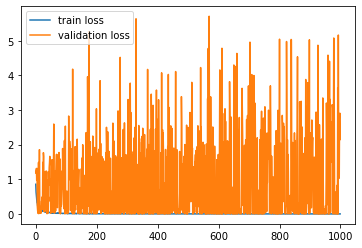

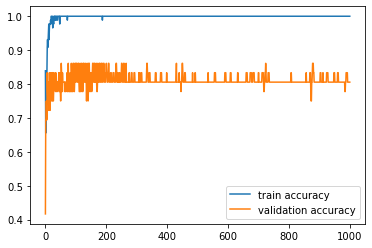

KeyError: 'f1'

<Figure size 432x288 with 0 Axes>

In [14]:
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.savefig('LossValidation_loss')

# Accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

# F1
plt.plot(r.history['f1'], label='train F1')
plt.plot(r.history['val_f1'], label='validation F1')
plt.legend()
plt.show()
plt.savefig('F1Val_F1')

# precision
plt.plot(r.history['precision'], label='train precision')
plt.plot(r.history['val_precision'], label='validation precision')
plt.legend()
plt.show()
plt.savefig('precisionVal_precision')